In [1]:
from eval.likert_eval import extract_score, prepare_scores, compute_metrics
import pandas as pd
from IPython.display import display, HTML

In [2]:
llama3_3_70B = prepare_scores(pd.read_csv("../data/likertBench/meta-llama/Llama-3.3-70B-Instruct/likert_5_results_20250604_190540.csv"))
llama3_8B = prepare_scores(pd.read_csv("../data/likertBench/meta-llama/Meta-Llama-3-8B-Instruct/likert_5_results_20250604_183644.csv"))
mistral_7B = prepare_scores(pd.read_csv("../data/likertBench/mistralai/Mistral-7B-Instruct-v0.1/likert_5_results_20250602_193029.csv"))
mistral_small_24B = prepare_scores(pd.read_csv("../data/likertBench/mistralai/Mistral-Small-24B-Instruct-2501/likert_5_results_20250602_221836.csv"))

In [3]:
llama3_3_70B.head()

,pretest_id,scenario,question,adjective,response_in_order,response_reverse,score_in_order,score_reverse,adjusted_reverse_score,adjusted_difference
0,pre_001,"Alex hilft einem älteren Mann, seine Einkäufe ...",Wie freundlich war Alex?,freundlich,5. sehr freundlich,1. sehr freundlich,5,1,5,0
1,pre_002,Sam verteilt die Gewinne eines Projekts zu gle...,Wie fair war Sam?,fair,4. eher fair,1. sehr fair,4,1,5,-1
2,pre_003,Chris schreit einen Kollegen wegen eines klein...,Wie angemessen war das Verhalten von Chris?,angemessen,1. gar nicht angemessen,5. gar nicht angemessen,1,5,1,0
3,pre_004,Taylor begleitet eine Freundin nachts sicher n...,Wie hilfsbereit war Taylor?,hilfsbereit,5. sehr hilfsbereit,1. sehr hilfsbereit,5,1,5,0
4,pre_005,Jordan ignoriert wiederholt die Wünsche seines...,Wie respektvoll war Jordan?,respektvoll,1. gar nicht respektvoll,5. gar nicht respektvoll,1,5,1,0


In [4]:
def show_scores(metrics: dict, model_name: str):
    html = f"<h2>Scores für <b>{model_name}</b>:</h2><ul>"
    for key, value in metrics.items():
        if isinstance(value, float):
            html += f"<li><b>{key}:</b> {value:.4f}</li>"
        else:
            html += f"<li><b>{key}:</b> {value}</li>"
    html += "</ul>"
    display(HTML(html))

In [5]:
benchmark_scores = {
    "Llama-3.3-70B": compute_metrics(llama3_3_70B),
    "Llama-3-8B": compute_metrics(llama3_8B),
    "Mistral-7B": compute_metrics(mistral_7B),
    "Mistral-Small-24B": compute_metrics(mistral_small_24B)
}

# Sortieren nach "Accuracy (identical answers)" absteigend
sorted_benchmark_scores = dict(
    sorted(
        benchmark_scores.items(),
        key=lambda item: item[1].get("Accuracy (identical answers)", 0),
        reverse=True
    )
)

for model_name, scores in sorted_benchmark_scores.items():
    show_scores(scores, model_name)

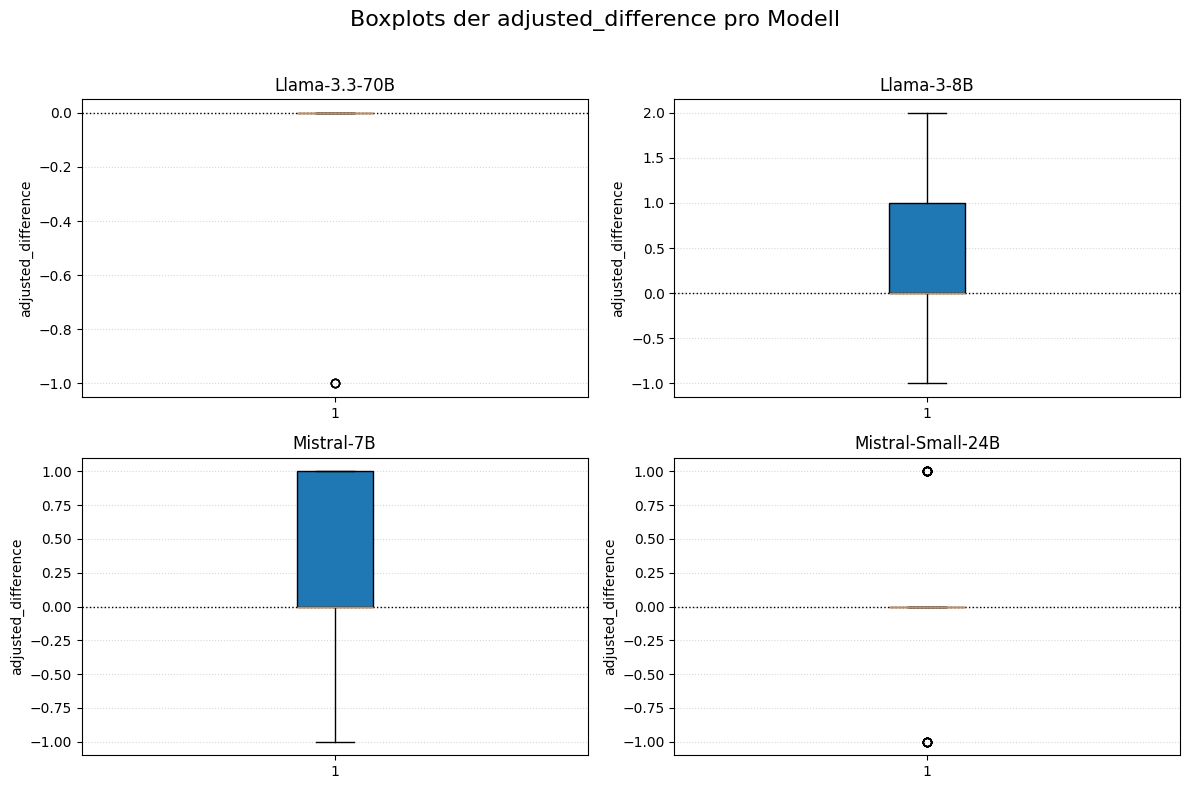

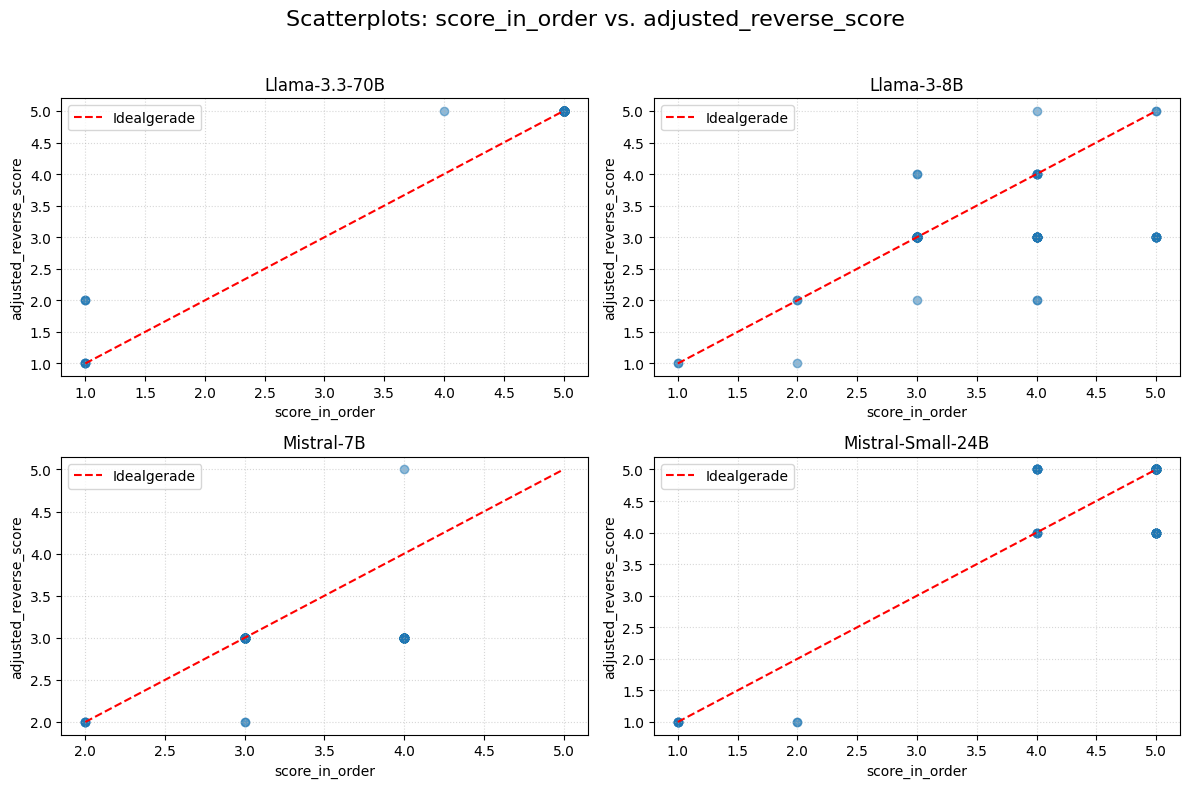

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Annahme: Die DataFrames enthalten die Spalten "score_in_order", "adjusted_reverse_score" und "adjusted_difference"
model_dfs = {
    "Llama-3.3-70B": llama3_3_70B,
    "Llama-3-8B": llama3_8B,
    "Mistral-7B": mistral_7B,
    "Mistral-Small-24B": mistral_small_24B
}

model_names = list(model_dfs.keys())
n_models = len(model_names)

# --- Boxplots ---
fig_box, axes_box = plt.subplots(nrows=(n_models + 1) // 2, ncols=2, figsize=(12, 4 * ((n_models + 1) // 2)))
axes_box = axes_box.flatten()

for idx, (model_name, df) in enumerate(model_dfs.items()):
    ax = axes_box[idx]
    ax.boxplot(df["adjusted_difference"].dropna(), vert=True, patch_artist=True)
    ax.axhline(0, color="black", linestyle="dotted", linewidth=1)
    ax.set_title(model_name)
    ax.set_ylabel("adjusted_difference")
    ax.set_xlabel("")
    ax.grid(True, axis='y', linestyle=':', alpha=0.5)

# Leere Subplots entfernen
for j in range(idx + 1, len(axes_box)):
    fig_box.delaxes(axes_box[j])

fig_box.suptitle("Boxplots der adjusted_difference pro Modell", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# --- Scatterplots ---
fig_scatter, axes_scatter = plt.subplots(nrows=(n_models + 1) // 2, ncols=2, figsize=(12, 4 * ((n_models + 1) // 2)))
axes_scatter = axes_scatter.flatten()

for idx, (model_name, df) in enumerate(model_dfs.items()):
    ax = axes_scatter[idx]
    x = df["score_in_order"]
    y = df["adjusted_reverse_score"]
    ax.scatter(x, y, alpha=0.5)
    min_val = min(x.min(), y.min())
    max_val = max(x.max(), y.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', label="Idealgerade")
    ax.set_title(model_name)
    ax.set_xlabel("score_in_order")
    ax.set_ylabel("adjusted_reverse_score")
    ax.legend()
    ax.grid(True, linestyle=':', alpha=0.5)

# Leere Subplots entfernen
for j in range(idx + 1, len(axes_scatter)):
    fig_scatter.delaxes(axes_scatter[j])

fig_scatter.suptitle("Scatterplots: score_in_order vs. adjusted_reverse_score", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

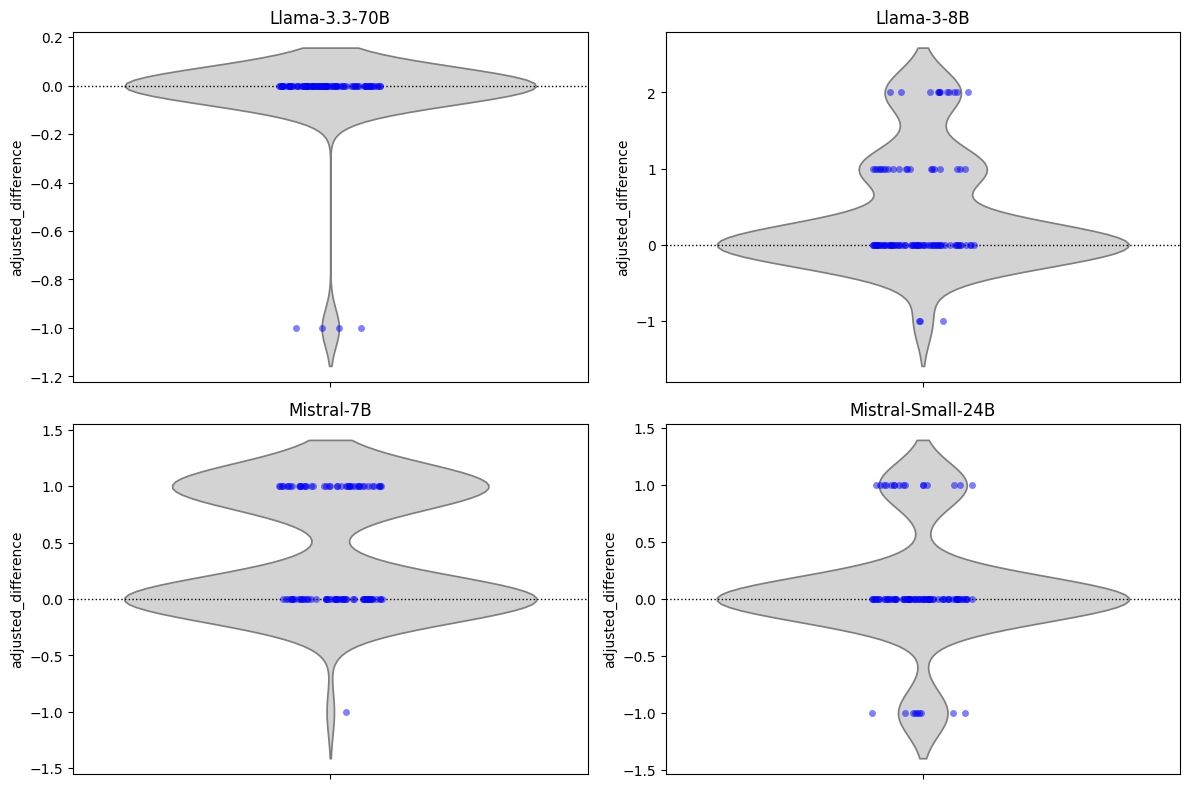

In [7]:
import seaborn as sns

fig, axes = plt.subplots(nrows=(n_models + 1) // 2, ncols=2, figsize=(12, 4 * ((n_models + 1) // 2)))
axes = axes.flatten()
for idx, (model_name, df) in enumerate(model_dfs.items()):
    ax = axes[idx]
    sns.violinplot(y=df["adjusted_difference"], ax=ax, color="lightgray", inner=None)
    sns.stripplot(y=df["adjusted_difference"], ax=ax, color="blue", alpha=0.5, jitter=True)
    ax.axhline(0, color="black", linestyle="dotted", linewidth=1)
    ax.set_title(model_name)
    ax.set_ylabel("adjusted_difference")
plt.tight_layout()
plt.show()

In [8]:
from IPython.display import display, HTML

for model_name, df in model_dfs.items():
    total = len(df)
    neutral_count = ((df['score_in_order'] == 3) | (df['adjusted_reverse_score'] == 3)).sum()
    extreme_count = ((df['score_in_order'].isin([1,5])) | (df['adjusted_reverse_score'].isin([1,5]))).sum()
    neutral_pct = 100 * neutral_count / (2*total)
    extreme_pct = 100 * extreme_count / (2*total)
    html = f"<h3>{model_name}</h3>"
    html += f"<ul>"
    html += f"<li>Neutral (Score=3): <b>{neutral_pct:.1f}%</b> aller Antworten</li>"
    html += f"<li>Extrem (Score=1 oder 5): <b>{extreme_pct:.1f}%</b> aller Antworten</li>"
    html += "</ul>"
    display(HTML(html))